CNN - dealt with data point that are spatially related to one another, group of pixels holds information about an image.


RNN - specializes in dealing with sequential or time-varying data. For example 'rhythm' - the data has temporal relationship to one another. 
The neurons in RNN form a directed graph on a temporal sequence, introducing the memory into NN. Memory is used to remember the previous input and process the current input with account of history

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

Typical RNN architecture:
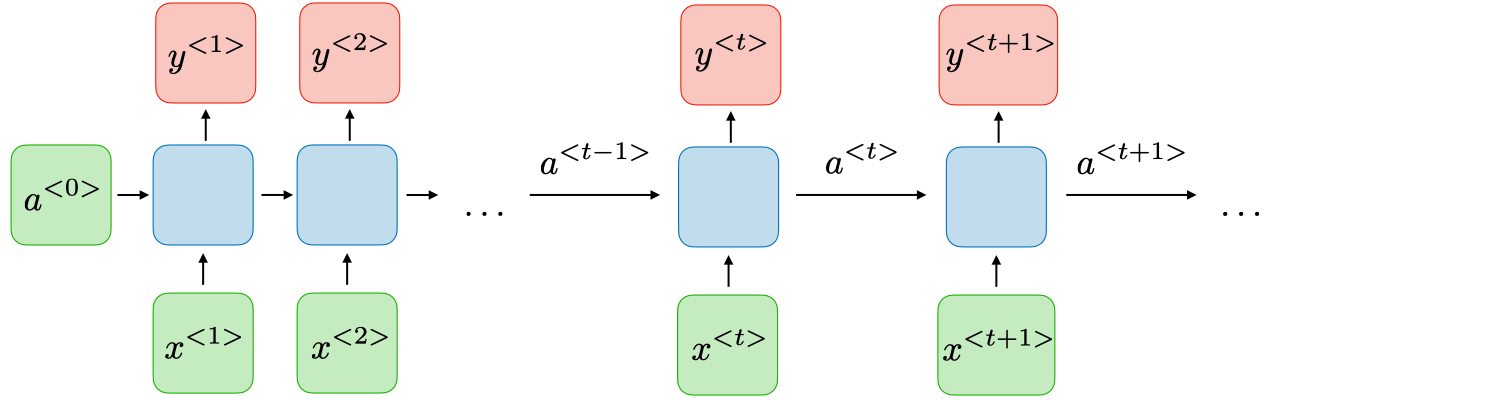

RR is capable of taking in an input sequence of a variable size and produce a variably sized output sequence, thereby `тем самым` performing a variable number of computations as opposed to a fixed number of computations in a fully connected NN.

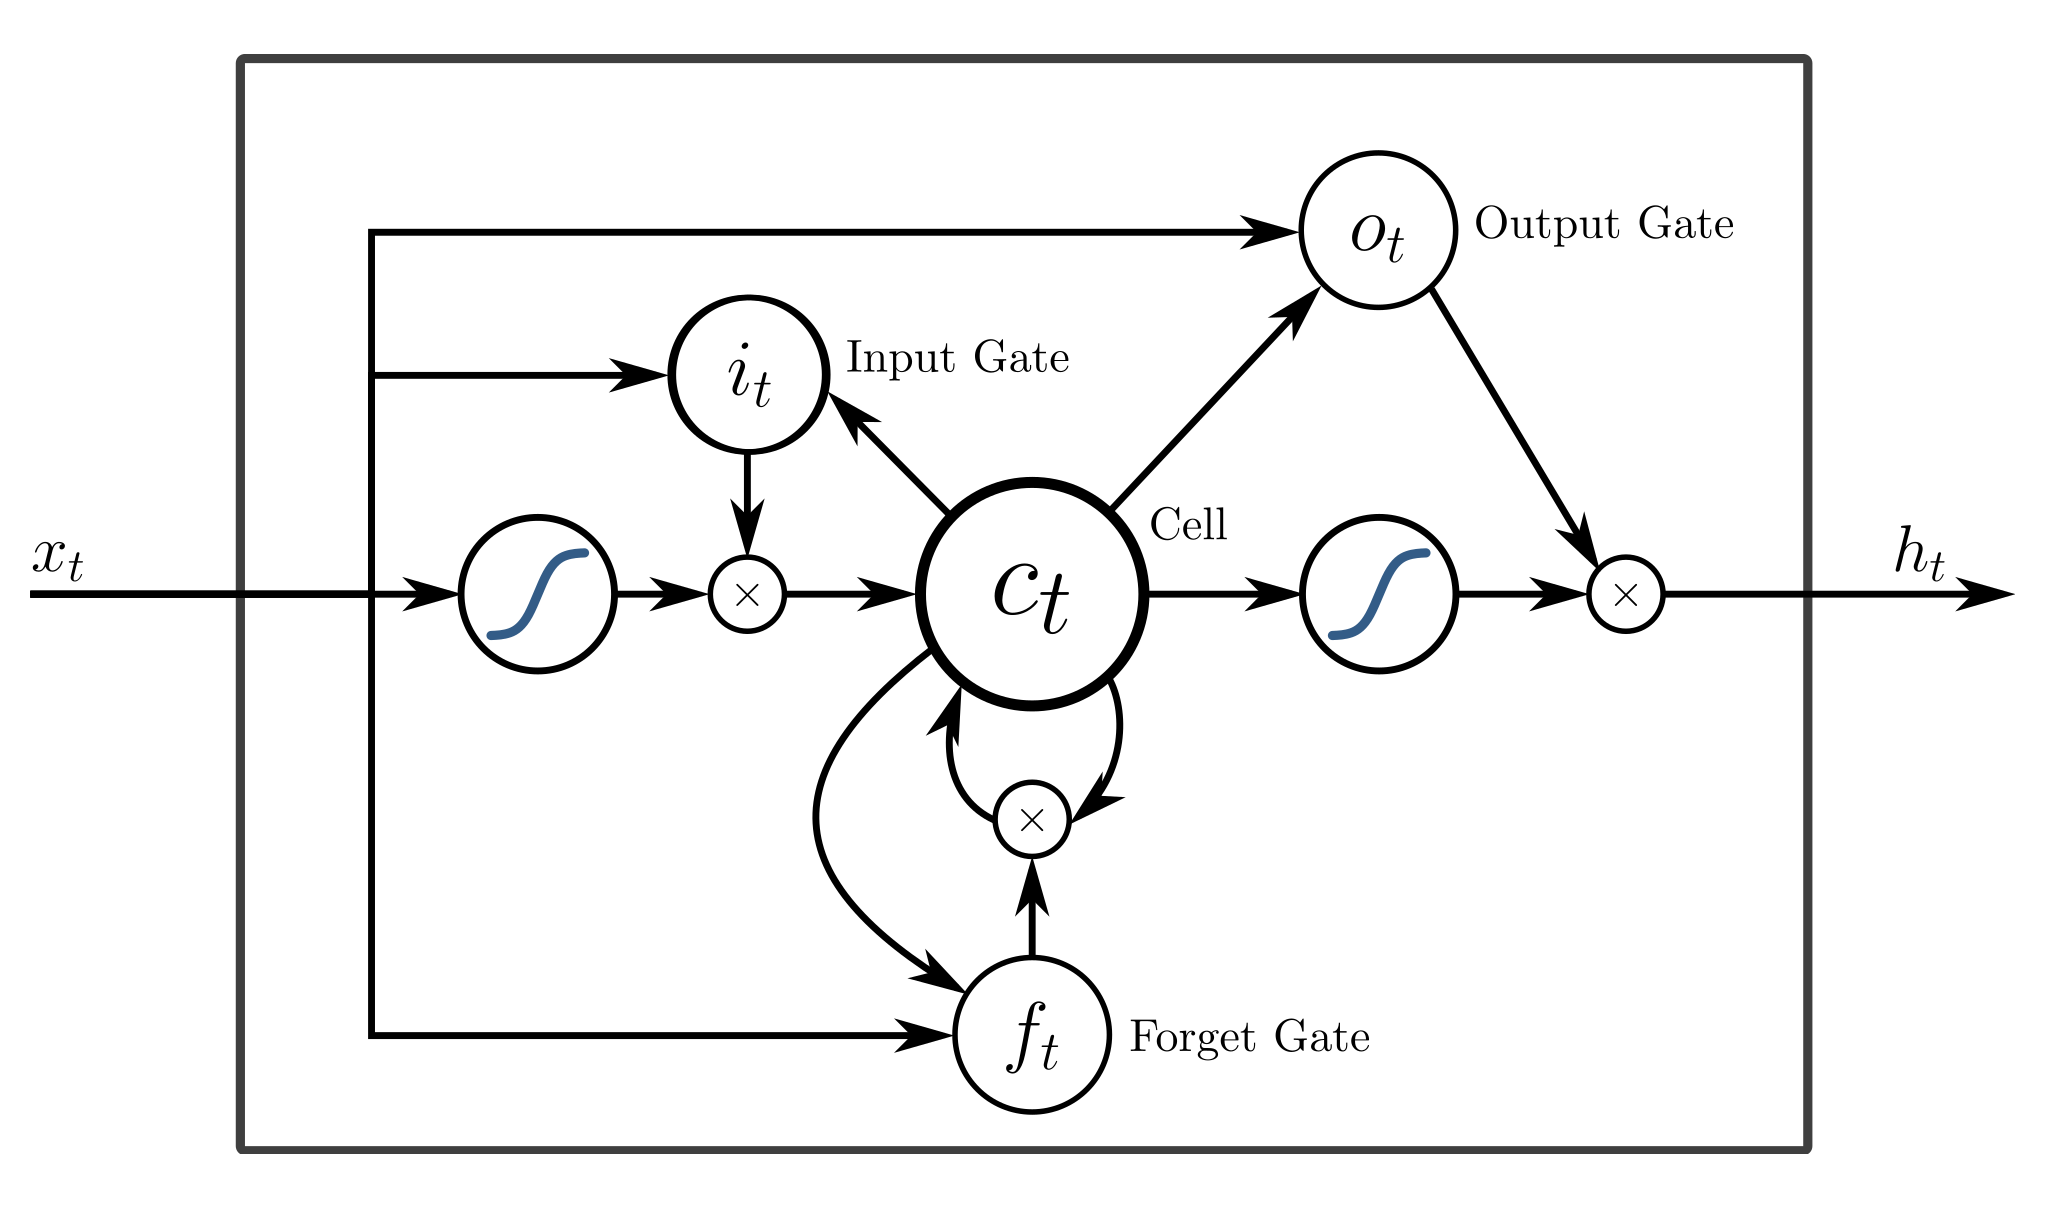

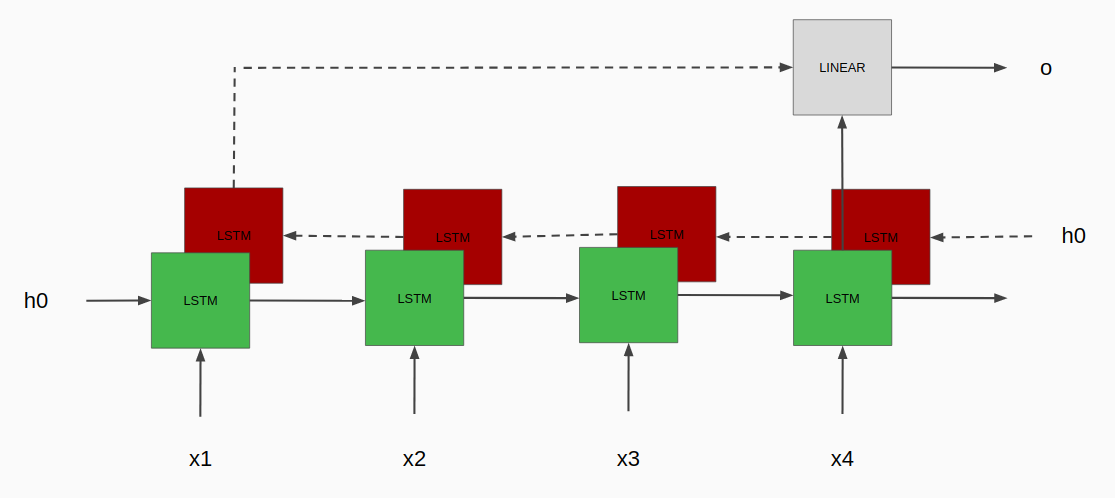

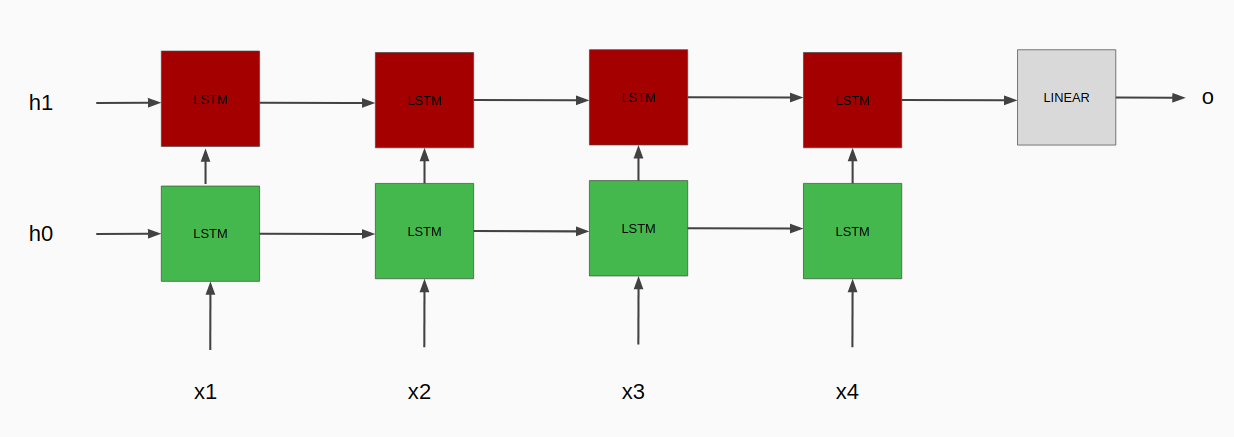

In [1]:
tokenizer = lambda words: words.split()

# Creating fields

In [2]:
# Fields let us define the datatype and help us create tensors out of textual data
# by specifying the set of operations to be performed on the data.
from torchtext.data import Field

In [3]:
# Fore review we set `sequential` beause this adata is a sequence
# sequential: Whether the datatype represents sequential data. If False,
# no tokenization is applied.
Review = Field(sequential=True, tokenize=tokenizer, lower=True)

In [4]:
# use_vocab: Whether to use a Vocab object. If False, the data in this
# field should already be numerical. Default: True.
Label = Field(sequential=False, use_vocab=False)

In [5]:
# add token at beginning and end of an inmput string
SequenceField = Field(tokenize=str.split, init_token='<sos>', eos_token='<eos>', lower=True)

In [6]:
# set the sequence to a fixed length:
# fix_length: A fixed length that all examples using this field will be
# padded to, or None for flexible sequence lengths. Default: None.
SequenceField = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True, fix_length=50)

In [7]:
# set unknown token
# set the batch dimension as the first dimension
SequenceField = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True,\
                      unk_token='<unk>', batch_first=True)

# Developing a dataset


TorchText can read data from text, json, csv, tsv and directories and convert them into a dataset. Dataset are preprocessed blocks of data that are read into memory

In [8]:
from torchtext.data  import TabularDataset

In [9]:
Review = Field(sequential=True, tokenize=str.split, lower=True)
Label = Field(sequential=False, use_vocab=False)

In [10]:
# select the training columns
# Tuples with column name and textual transformations that are to be applied
train_datafields = [("id",None), ('content', Review), ('Bussiness', Label),\
                    ('SciTech', Label), ('Sports', Label), ('World', Label)]
# testint columns
test_datafields = [('id', None), ('content', Review)]

# read the training and validation files
train, valid = TabularDataset.splits(path='data', train='4_news_train.csv', validation='4_news_valid.csv',\
                                    format='csv', skip_header=True, fields=train_datafields)

test = TabularDataset(path='data/4_news_test.csv',   format='csv', skip_header=True, fields=test_datafields)

In [11]:
# build library of  words with a minimum presence of two times in the dataset.
Review.build_vocab(train, min_freq=2)

Read more https://torchtext.readthedocs.io/en/latest/data.html#torchtext-data

# Developing iterators

Iterators are used to load batches of data from the dataset. They provide methds to make loading data and moving data to the appropriate device easier. We could use the iterator objects to iterate over the data while running throught the epochs.

In [12]:
from torchtext.data import BucketIterator
import torch

https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a

In [13]:
BATCH_SIZE=128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device type =',device.type)

train_iter, valid_iter, test_iter = BucketIterator.splits((train, valid, test),
                                                          batch_size=BATCH_SIZE,
                                                          device=device,
                                                          sort_key=lambda x: len(x.comment_text),
                                                          sort_within_batch=False)

Device type = cuda


In [49]:
data = next(train_iter.batches)

In [60]:
row = data[6]
vars(row)

{'content': ['the',
  'british',
  'government',
  'has',
  'announced',
  'plans',
  'to',
  'send',
  'a',
  'top',
  'foreign',
  'office',
  'representative',
  'to',
  'north',
  'korea',
  'in',
  'september.',
  'junior',
  'minister',
  'for',
  'east',
  'asia',
  'bill',
  'rammell',
  'will',
  'become',
  'the',
  'first',
  'british',
  'minister',
  'to',
  'visit'],
 'Bussiness': '0',
 'SciTech': '0',
 'Sports': '0',
 'World': '1'}

In [62]:
row.content

['the',
 'british',
 'government',
 'has',
 'announced',
 'plans',
 'to',
 'send',
 'a',
 'top',
 'foreign',
 'office',
 'representative',
 'to',
 'north',
 'korea',
 'in',
 'september.',
 'junior',
 'minister',
 'for',
 'east',
 'asia',
 'bill',
 'rammell',
 'will',
 'become',
 'the',
 'first',
 'british',
 'minister',
 'to',
 'visit']

In [38]:
for data in train_iter.data():
    print(data)
    break

In [44]:
data.

'0'

# Exploring word embeddings

Word embeddings are learned representations of words. They are dense representations of words, where each word is assigned a vector, that is, a real-valued vector in a pre-defined vector space. 

`vocab` module deals with embeddings. Download pretrained embeddings by name. 6 billion tokens with 100 embedding domension vector.

In [14]:

from torchtext import vocab

In [15]:
vec = vocab.Vectors('glove.6B.100d.txt',
                   cache='./vec/glove_embedding/',
                   url='http://nlp.stanford.edu/data/glove.6B.zip')

vec

In [16]:
# Build the vocabulary form the pretrained vector by applying it to the field object:
Review.build_vocab(train, min_freq=2, vectors=vec)

In [17]:
len(Review.vocab)

9760

In [18]:
Review.process(['I have a bad news for you  there'.split()])

tensor([[   0],
        [  29],
        [   3],
        [1806],
        [ 202],
        [  10],
        [ 164],
        [ 143]])

We could could create embeddings from our nn

https://torchtext.readthedocs.io/en/latest/vocab.html?highlight=embedding#module-torchtext.vocab

# Building an LSTM network
Long short-term memroy networks is type of recurrent neural network that has internal gates that helps in better information persistence. These gates are tiny nn that control when information needs to be sabed and when it can be erased or forgotten.

RNNs suffers from vanishing and exploding gradients, making it difficult to learn long-term dependencies.

LSTMs are resistant to exploding and vanishing gradients, although it is still mathematically possbile

$\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}$

In [19]:
import torch.nn as nn

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, outptu_dim, dropout):
        super().__init__()
        # A simple lookup talbe that stores embeddings of a fixed dictionary and size
        # embedding layer
        self.embedding = nn.Embedding(len(Review.vocab), embedding_dim=embedding_dim)
        # LSTM layer
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, outptu_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [21]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT = 0.5

model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

In [22]:
model

LSTMClassifier(
  (embedding): Embedding(9760, 100)
  (rnn): LSTM(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
import tqdm

In [25]:
from torch.optim import Adam

In [28]:
optimizer = Adam(model.parameters())

In [23]:
epoch = 10

In [63]:
ce_loss = torch.nn.CrossEntropyLoss()

In [72]:
for i in tqdm.notebook.tqdm(range(10)):
    train_loss = 0
    valid_loss = 0
    model.train()
    for batch_idx, data in enumerate(train_iter.batches):
        # why zero_grad
        optimizer.zero_grad()
        embed = Review.process(row.content)
        print(embed)
        output = model(embed.to(device))
        loss = ce_loss(output, target)
        loss.backward()
        optimizer.step()
        # Q - why data.size(0)?
        train_loss += loss.item()* data.size(0)

tensor([[3818, 6828,    0,    0,    3, 4508, 3818, 9025,    3, 3818,    0, 2639,
         8849, 3818, 8450,    0,  337, 9025,    0,    0,    0,    0,    3, 6828,
         8849,    0, 6828, 3818,    0, 6828,    0, 3818,    0],
        [   0, 8849, 2639,    3, 8450,    0, 2639,    0,    1, 2639, 2639,    0,
            0, 2639, 2639, 2639, 8450,    0,    0,  337, 2639,    3, 9025,  337,
            3,  337,    0,    0,  337, 8849,  337, 2639,  337],
        [   0,  337,    0, 9025, 8450,    3,    1, 8450,    1, 4508, 8849,    0,
         4508,    1, 8849, 8849,    1, 4508, 8450, 8450, 8849, 9025,  337,    0,
            0,    0, 7015,    0, 8849,  337, 8450,    1, 9025],
        [   1, 3818,    0,    1, 2639, 8450,    1, 7310,    1,    1,    0,  337,
         8849,    1, 3818,    0,    1, 3818,  337,  337,    1, 3818,    3,    0,
            0,    0, 2639,    1, 9025, 3818,  337,    1,  337],
        [   1,  337, 8849,    1,    0, 9025,    1,    1,    1,    1,  337, 7015,
            0, 

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_index_select